In [1]:
import numpy as np
import os 
import pandas as pd
import time 
import seaborn as sns
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, train_test_split
import sklearn
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import joblib
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
train = pd.read_csv('train.csv')
submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [3]:
tran = train.drop_duplicates().reset_index(drop=True)

In [4]:
train.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524164 entries, 0 to 524163
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         524164 non-null  int64  
 1   RhythmScore                524164 non-null  float64
 2   AudioLoudness              524164 non-null  float64
 3   VocalContent               524164 non-null  float64
 4   AcousticQuality            524164 non-null  float64
 5   InstrumentalScore          524164 non-null  float64
 6   LivePerformanceLikelihood  524164 non-null  float64
 7   MoodScore                  524164 non-null  float64
 8   TrackDurationMs            524164 non-null  float64
 9   Energy                     524164 non-null  float64
 10  BeatsPerMinute             524164 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 44.0 MB


In [6]:
train.describe()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
count,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000,524164.000000
mean,262081.500000,0.632843,-8.379014,0.074443,0.262913,0.117690,0.178398,0.555843,241903.692949,0.500923,119.034899
std,151313.257587,0.156899,4.616221,0.049939,0.223120,0.131845,0.118186,0.225480,59326.601501,0.289952,26.468077
min,0.000000,0.076900,-27.509725,0.023500,0.000005,0.000001,0.024300,0.025600,63973.000000,0.000067,46.718000
25%,131040.750000,0.515850,-11.551933,0.023500,0.069413,0.000001,0.077637,0.403921,207099.876625,0.254933,101.070410
50%,262081.500000,0.634686,-8.252499,0.066425,0.242502,0.074247,0.166327,0.564817,243684.058150,0.511800,118.747660
75%,393122.250000,0.739179,-4.912298,0.107343,0.396957,0.204065,0.268946,0.716633,281851.658500,0.746000,136.686590
max,524163.000000,0.975000,-1.357000,0.256401,0.995000,0.869258,0.599924,0.978000,464723.228100,1.000000,206.037000


In [7]:
epsilon = 1e-6
#调整数据
# --- Base conversions ---
train['TrackDurationMin'] = train['TrackDurationMs'] / 60000

# --- Ratios & balances ---
train['Energy_Acoustic_Ratio'] = train['Energy'] / (train['AcousticQuality'] + epsilon)
train['Vocal_Instrument_Balance'] = train['VocalContent'] / (train['InstrumentalScore'] + epsilon)
train['Vocal_share'] = train['VocalContent'] / (train['VocalContent'] + train['InstrumentalScore'] + epsilon)
train['Instrumental_to_Total'] = train['InstrumentalScore'] / (train['VocalContent'] + train['InstrumentalScore'] + epsilon)
train['Acoustic_to_Energy'] = train['AcousticQuality'] / (train['Energy'] + epsilon)

# --- Multiplicative interactions ---
train['MoodRhythm'] = train['MoodScore'] * train['RhythmScore']
train['RhythmEnergy'] = train['RhythmScore'] * train['Energy']
train['MoodAcoustic'] = train['MoodScore'] * train['AcousticQuality']
train['Vocal_Energy_Interaction'] = train['VocalContent'] * train['Energy']
train['PerformanceIntensity'] = train['LivePerformanceLikelihood'] * train['AudioLoudness']
train['Electronic_Proxy'] = (1 - train['AcousticQuality']) * train['Energy'] * train['RhythmScore']
train['Ambient_Proxy'] = train['AcousticQuality'] * (1 - train['Energy']) * (1 - train['RhythmScore'])
train['Ballad_Proxy'] = train['VocalContent'] * train['AcousticQuality'] * (1 - train['Energy']) * (1 - train['RhythmScore'])
train['Instrumental_Intensity_Proxy'] = train['InstrumentalScore'] * train['Energy'] * train['AudioLoudness']
train['Mood_Rhythm_Energy'] = train['MoodScore'] * train['RhythmScore'] * train['Energy']

# --- Differences ---
train['Energy_Mood_diff'] = train['Energy'] - train['MoodScore']
train['Energy_Mood_absdiff'] = np.abs(train['Energy_Mood_diff'])
train['Rhythm_Instrument_diff'] = train['RhythmScore'] - train['InstrumentalScore']
train['Vocal_Instrument_diff'] = train['VocalContent'] - train['InstrumentalScore']

# --- Log / nonlinear transforms ---
train['TrackDurationMin_log'] = np.log1p(train['TrackDurationMin'])
train['Rhythm_sqrt'] = np.sqrt(train['RhythmScore'])
train['AudioLoudness_sq'] = train['AudioLoudness'] ** 2
train['Energy_cbrt'] = np.cbrt(train['Energy'])
train['log_Rhythm_over_Acoustic'] = np.log1p(train['RhythmScore'] / (train['AcousticQuality'] + epsilon))
train['log_Instrumental_Energy'] = np.log1p(train['InstrumentalScore'] * train['Energy'])

# --- Composite interactions ---
train['Rhythm_Energy_Loudness'] = train['RhythmScore'] * train['Energy'] * (train['AudioLoudness'] + 20)
train['Instrumental_Energy'] = train['InstrumentalScore'] * train['Energy']
train['Vocal_Rhythm_Energy'] = train['VocalContent'] * train['RhythmScore'] * train['Energy']
train['RhythmEnergy_log'] = np.log1p(train['RhythmScore'] * train['Energy'])
train['RhythmEnergy_over_Instrument'] = (train['RhythmScore'] * train['Energy']) / (train['InstrumentalScore'] + epsilon)

# --- Proxies with sigmoid (soft categories) ---
def sigmoid(x): return 1 / (1 + np.exp(-x))

x = 3*(train['Energy'] - 0.5) + 2*(train['RhythmScore'] - 0.5) + 0.2*(train['AudioLoudness'] + 8)
train['Dance_Proxy'] = sigmoid(x)

y = 4*(train['VocalContent']) + 3*(train['AcousticQuality']) - 5*(train['Energy']) - 4*(train['RhythmScore'])
train['Ballad_Proxy_Score'] = sigmoid(y)

# --- Relative rankings ---
train['Rhythm_rank'] = train['RhythmScore'].rank(pct=True)
train['Energy_rank'] = train['Energy'].rank(pct=True)
train['RhythmEnergy_rank_prod'] = train['Rhythm_rank'] * train['Energy_rank']

# --- Ratios with loudness ---
train['Rhythm_Loudness_Ratio'] = train['RhythmScore'] / (train['AudioLoudness'] + epsilon)
train['Rhythm_Loudness_Ratio_clipped'] = np.clip(train['RhythmScore'] / (train['AudioLoudness'] + 20 + epsilon), -100, 100)

# --- Duration transforms ---
train['TrackDurationMin_inv'] = 1 / (train['TrackDurationMin'] + epsilon)

# --- NEW: Statistical moment features ---
# Calculate rolling statistics for key features
for col in ['Energy', 'RhythmScore', 'AudioLoudness', 'MoodScore']:
    train[f'{col}_zscore'] = (train[col] - train[col].mean()) / train[col].std()
    train[f'{col}_skewness'] = (train[col] - train[col].mean())**3 / train[col].std()**3

# --- NEW: Polynomial features ---
for col in ['Energy', 'RhythmScore', 'AudioLoudness']:
    train[f'{col}_squared'] = train[col] ** 2
    train[f'{col}_cubed'] = train[col] ** 3

# --- NEW: Audio properties combinations ---
train['Loudness_Energy_Ratio'] = train['AudioLoudness'] / (train['Energy'] + epsilon)
train['Dynamic_Range_Proxy'] = train['AudioLoudness'].max() - train['AudioLoudness'].min()  # This might need adjustment

# --- NEW: Genre-like proxies based on statistics ---
train['Mellow_Proxy'] = train['AcousticQuality'] * train['MoodScore'] * (1 - train['Energy'])

# --- NEW: Vocal prominence score ---
train['Vocal_Prominence'] = train['VocalContent'] * (1 - train['InstrumentalScore']) * train['AudioLoudness']

# --- NEW: Performance quality indicators ---
train['Live_Energy_Balance'] = train['LivePerformanceLikelihood'] * train['Energy']
train['Studio_Polish_Proxy'] = (1 - train['LivePerformanceLikelihood']) * train['AudioLoudness']

# --- NEW: Complex interaction terms ---
train['Full_Production_Score'] = (
    train['Energy'] * train['AudioLoudness'] * 
    (1 - train['AcousticQuality']) * train['RhythmScore']
)

train = train.replace([np.inf, -np.inf], np.nan)

In [8]:
epsilon = 1e-6
#调整数据
# --- Base conversions ---
test['TrackDurationMin'] = test['TrackDurationMs'] / 60000

# --- Ratios & balances ---
test['Energy_Acoustic_Ratio'] = test['Energy'] / (test['AcousticQuality'] + epsilon)
test['Vocal_Instrument_Balance'] = test['VocalContent'] / (test['InstrumentalScore'] + epsilon)
test['Vocal_share'] = test['VocalContent'] / (test['VocalContent'] + test['InstrumentalScore'] + epsilon)
test['Instrumental_to_Total'] = test['InstrumentalScore'] / (test['VocalContent'] + test['InstrumentalScore'] + epsilon)
test['Acoustic_to_Energy'] = test['AcousticQuality'] / (test['Energy'] + epsilon)

# --- Multiplicative interactions ---
test['MoodRhythm'] = test['MoodScore'] * test['RhythmScore']
test['RhythmEnergy'] = test['RhythmScore'] * test['Energy']
test['MoodAcoustic'] = test['MoodScore'] * test['AcousticQuality']
test['Vocal_Energy_Interaction'] = test['VocalContent'] * test['Energy']
test['PerformanceIntensity'] = test['LivePerformanceLikelihood'] * test['AudioLoudness']
test['Electronic_Proxy'] = (1 - test['AcousticQuality']) * test['Energy'] * test['RhythmScore']
test['Ambient_Proxy'] = test['AcousticQuality'] * (1 - test['Energy']) * (1 - test['RhythmScore'])
test['Ballad_Proxy'] = test['VocalContent'] * test['AcousticQuality'] * (1 - test['Energy']) * (1 - test['RhythmScore'])
test['Instrumental_Intensity_Proxy'] = test['InstrumentalScore'] * test['Energy'] * test['AudioLoudness']
test['Mood_Rhythm_Energy'] = test['MoodScore'] * test['RhythmScore'] * test['Energy']

# --- Differences ---
test['Energy_Mood_diff'] = test['Energy'] - test['MoodScore']
test['Energy_Mood_absdiff'] = np.abs(test['Energy_Mood_diff'])
test['Rhythm_Instrument_diff'] = test['RhythmScore'] - test['InstrumentalScore']
test['Vocal_Instrument_diff'] = test['VocalContent'] - test['InstrumentalScore']

# --- Log / nonlinear transforms ---
test['TrackDurationMin_log'] = np.log1p(test['TrackDurationMin'])
test['Rhythm_sqrt'] = np.sqrt(test['RhythmScore'])
test['AudioLoudness_sq'] = test['AudioLoudness'] ** 2
test['Energy_cbrt'] = np.cbrt(test['Energy'])
test['log_Rhythm_over_Acoustic'] = np.log1p(test['RhythmScore'] / (test['AcousticQuality'] + epsilon))
test['log_Instrumental_Energy'] = np.log1p(test['InstrumentalScore'] * test['Energy'])

# --- Composite interactions ---
test['Rhythm_Energy_Loudness'] = test['RhythmScore'] * test['Energy'] * (test['AudioLoudness'] + 20)
test['Instrumental_Energy'] = test['InstrumentalScore'] * test['Energy']
test['Vocal_Rhythm_Energy'] = test['VocalContent'] * test['RhythmScore'] * test['Energy']
test['RhythmEnergy_log'] = np.log1p(test['RhythmScore'] * test['Energy'])
test['RhythmEnergy_over_Instrument'] = (test['RhythmScore'] * test['Energy']) / (test['InstrumentalScore'] + epsilon)

# --- Proxies with sigmoid (soft categories) ---
def sigmoid(x): return 1 / (1 + np.exp(-x))

x = 3*(test['Energy'] - 0.5) + 2*(test['RhythmScore'] - 0.5) + 0.2*(test['AudioLoudness'] + 8)
test['Dance_Proxy'] = sigmoid(x)

y = 4*(test['VocalContent']) + 3*(test['AcousticQuality']) - 5*(test['Energy']) - 4*(test['RhythmScore'])
test['Ballad_Proxy_Score'] = sigmoid(y)

# --- Relative rankings ---
test['Rhythm_rank'] = test['RhythmScore'].rank(pct=True)
test['Energy_rank'] = test['Energy'].rank(pct=True)
test['RhythmEnergy_rank_prod'] = test['Rhythm_rank'] * test['Energy_rank']

# --- Ratios with loudness ---
test['Rhythm_Loudness_Ratio'] = test['RhythmScore'] / (test['AudioLoudness'] + epsilon)
test['Rhythm_Loudness_Ratio_clipped'] = np.clip(test['RhythmScore'] / (test['AudioLoudness'] + 20 + epsilon), -100, 100)

# --- Duration transforms ---
test['TrackDurationMin_inv'] = 1 / (test['TrackDurationMin'] + epsilon)

# --- NEW: Statistical moment features ---
# Calculate rolling statistics for key features
for col in ['Energy', 'RhythmScore', 'AudioLoudness', 'MoodScore']:
    test[f'{col}_zscore'] = (test[col] - test[col].mean()) / test[col].std()
    test[f'{col}_skewness'] = (test[col] - test[col].mean())**3 / test[col].std()**3

# --- NEW: Polynomial features ---
for col in ['Energy', 'RhythmScore', 'AudioLoudness']:
    test[f'{col}_squared'] = test[col] ** 2
    test[f'{col}_cubed'] = test[col] ** 3

# --- NEW: Audio properties combinations ---
test['Loudness_Energy_Ratio'] = test['AudioLoudness'] / (test['Energy'] + epsilon)
test['Dynamic_Range_Proxy'] = test['AudioLoudness'].max() - test['AudioLoudness'].min()  # This might need adjustment

# --- NEW: Genre-like proxies based on statistics ---
test['Mellow_Proxy'] = test['AcousticQuality'] * test['MoodScore'] * (1 - test['Energy'])

# --- NEW: Vocal prominence score ---
test['Vocal_Prominence'] = test['VocalContent'] * (1 - test['InstrumentalScore']) * test['AudioLoudness']

# --- NEW: Performance quality indicators ---
test['Live_Energy_Balance'] = test['LivePerformanceLikelihood'] * test['Energy']
test['Studio_Polish_Proxy'] = (1 - test['LivePerformanceLikelihood']) * test['AudioLoudness']

# --- NEW: Complex interaction terms ---
test['Full_Production_Score'] = (
    test['Energy'] * test['AudioLoudness'] * 
    (1 - test['AcousticQuality']) * test['RhythmScore']
)

test = test.replace([np.inf, -np.inf], np.nan)

In [9]:
#train.head()
test.head()

,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,...,RhythmScore_cubed,AudioLoudness_squared,AudioLoudness_cubed,Loudness_Energy_Ratio,Dynamic_Range_Proxy,Mellow_Proxy,Vocal_Prominence,Live_Energy_Balance,Studio_Polish_Proxy,Full_Production_Score
0,524164,0.410013,-16.794967,0.023500,0.232910,0.012689,0.271585,0.664321,302901.5498,0.424867,...,0.068928,282.070911,-4737.371608,-39.529878,26.085731,0.088989,-0.389674,0.115388,-12.233698,-2.244274
1,524165,0.463071,-1.357000,0.141818,0.057725,0.257942,0.097624,0.829552,221995.6643,0.846000,...,0.099298,1.841449,-2.498846,-1.604017,26.085731,0.007374,-0.142807,0.082590,-1.224525,-0.500928
2,524166,0.686569,-3.368928,0.167851,0.287823,0.210915,0.325909,0.304978,357724.0127,0.134067,...,0.323633,11.349675,-38.236239,-25.128564,26.085731,0.076012,-0.446209,0.043694,-2.270964,-0.220843
3,524167,0.885793,-5.598049,0.118488,0.000005,0.376906,0.134435,0.487740,271790.3989,0.316467,...,0.695018,31.338153,-175.432518,-17.689166,26.085731,0.000002,-0.413300,0.042544,-4.845478,-1.569258
4,524168,0.637391,-7.068160,0.126099,0.539073,0.068950,0.024300,0.591248,277728.5383,0.481067,...,0.258951,49.958883,-353.117369,-14.692652,26.085731,0.165397,-0.829835,0.011690,-6.896404,-0.998964


In [10]:
X = train.drop(columns=["id", "BeatsPerMinute"])
print(X.shape)
y = train["BeatsPerMinute"]
X_test = test.drop(columns=["id"])
# Train and test data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test.shape)
# Test and val data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

(524164, 69)
(104833, 69)


In [11]:
RANDOM_SEED = 42
N_TRIALS = 100                # adjust as needed (e.g., 100 or 200 for more thorough tuning)
N_ESTIMATORS_MAX = 5000     # maximum number of trees (as you requested)
EARLY_STOPPING_ROUNDS = 50   # stop early if no improvement for this many rounds
VERBOSE = False   

GPU_PARAMS = {
    "tree_method": "gpu_hist",
    "predictor": "gpu_predictor",
    "gpu_id": 0,
}

In [12]:
RANDOM_SEED = 42
USE_GPU = True               # set False if no GPU
OUTPUT_DIR = "final_model_cv_output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Best params from your Optuna run
best_params = {
    "learning_rate": 0.11936460732799715,
    "max_depth": 3,
    "min_child_weight": 2,
    "subsample": 0.5606560470740858,
    "colsample_bytree": 0.7661167052009941,
    "gamma": 0.631002480673827,
    "reg_alpha": 6.385721875114712,
    "reg_lambda": 1.673685454892917e-06,
    # fixed:
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "verbosity": 0,
}
GPU_PARAMS = {"tree_method": "gpu_hist", "predictor": "gpu_predictor", "gpu_id": 0}
if USE_GPU:
    best_params.update(GPU_PARAMS)

# Best iteration from your tuning
best_iteration = 16
if best_iteration is None or int(best_iteration) < 1:
    # fallback if not available, set a reasonable number
    n_estimators_final = 1000
else:
    n_estimators_final = int(best_iteration)

# CV settings
N_FOLDS = 10
shuffle_cv = True
print(X_test.shape)


(104833, 69)


In [13]:
# ---------------- Load data ----------------
# Try to use existing variables in the environment, otherwise load CSVs
try:
    train  # noqa: F821
    test   # noqa: F821
    y      # noqa: F821
    env_has_data = True
except NameError:
    env_has_data = False

In [14]:

if not env_has_data:
    if os.path.exists("train.csv") and os.path.exists("test.csv"):
        train = pd.read_csv("train.csv")
        test = pd.read_csv("test.csv")
        if "BeatsPerMinute" not in train.columns:
            raise KeyError("train.csv must contain target column 'BeatsPerMinute'")
        y = train["BeatsPerMinute"].copy()
    else:
        raise RuntimeError("Dataframes `train`/`test` not found and train.csv/test.csv missing.")

In [15]:
# Recreate splits exactly like your earlier code (train/val/test)
X = train.drop(columns=[c for c in ["id", "BeatsPerMinute"] if c in train.columns])
X_train_val, X_test_local, y_train_val, y_test_local = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=RANDOM_SEED
)

X_test = X_test_local
y_test = y_test_local

# Combine train+val to perform stratified K-fold CV
X_trainval = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_trainval = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

print(f"Train+Val shape: {X_trainval.shape}, Test shape: {X_test.shape}")

Train+Val shape: (419331, 69), Test shape: (104833, 69)


In [16]:
# ---------------- Create stratify bins for regression ----------------
def make_stratify_bins(y_series, n_bins=5):
    """Create quantile-based bins for stratified k-fold on a regression target.
       Falls back to uniform binning if qcut fails due to duplicate edges."""
    try:
        y_binned, bins = pd.qcut(y_series, q=n_bins, labels=False, retbins=True, duplicates="drop")
        # qcut may produce fewer bins if there are many duplicates; ensure labels are ints
        y_binned = y_binned.astype(int)
        return y_binned
    except Exception:
        # fallback: simple uniform discretization
        y_min, y_max = y_series.min(), y_series.max()
        if y_max == y_min:
            return np.zeros(len(y_series), dtype=int)
        scaled = (y_series - y_min) / (y_max - y_min + 1e-12)
        bins = np.floor(scaled * n_bins).astype(int)
        bins[bins == n_bins] = n_bins - 1
        return bins

y_bins = make_stratify_bins(y_trainval, n_bins=N_FOLDS)

# If number of unique bins < n_folds, reduce folds or adjust
unique_bins = np.unique(y_bins)
if unique_bins.shape[0] < N_FOLDS:
    # reduce n_splits to number of unique bins
    effective_folds = int(unique_bins.shape[0])
    print(f"Warning: only {effective_folds} unique bins found for stratification; using {effective_folds} folds.")
else:
    effective_folds = N_FOLDS

skf = StratifiedKFold(n_splits=effective_folds, shuffle=shuffle_cv, random_state=RANDOM_SEED)
print(X_test.shape)

(104833, 69)


In [17]:
# ---------------- CV training ----------------
test_preds_folds = []        # store per-fold test predictions
oof_preds = np.zeros(len(X_trainval))
fold_rmse_list = []
models = []
print(X_test.shape)

(104833, 69)


In [19]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

bp = best_params.copy()  # 你的初始最优参数

# —— 若用 GPU：统一成 XGBoost 3.x 的写法，并去掉可能重复的键
if 'USE_GPU' in globals() and USE_GPU:
    for k in ('tree_method', 'predictor', 'gpu_id', 'device'):
        bp.pop(k, None)
    bp.update({'device': 'cuda:0', 'tree_method': 'hist'})

# 只微调两个参数：max_depth & learning_rate（邻域）
md = int(bp['max_depth'])
lr = float(bp['learning_rate'])
param_grid = {
    'max_depth': [max(1, md-1), md, md+1],
    'learning_rate': [round(lr*0.9, 6), lr, round(lr*1.1, 6)],
}

# 固定其它参数不动
fixed = {k: v for k, v in bp.items() if k not in param_grid}

# 关键：只用**一次** kwargs，避免重复键
model_kwargs = {'random_state': RANDOM_SEED, 'n_jobs': 1, **fixed}
model = XGBRegressor(**model_kwargs)

gscv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=(rmse_scorer if 'rmse_scorer' in globals() else 'neg_root_mean_squared_error'),
    cv=(cv if 'cv' in globals() else 5),
    refit=True,
    n_jobs=1,
    verbose=0,
)

gscv.fit(X_trainval, y_trainval)

best_params_local = {**fixed, **gscv.best_params_}
print("best_params_local =", best_params_local)
print("best_cv_rmse =", -gscv.best_score_)



best_params_local = {'min_child_weight': 2, 'subsample': 0.5606560470740858, 'colsample_bytree': 0.7661167052009941, 'gamma': 0.631002480673827, 'reg_alpha': 6.385721875114712, 'reg_lambda': 1.673685454892917e-06, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'verbosity': 0, 'device': 'cuda:0', 'tree_method': 'hist', 'learning_rate': 0.107428, 'max_depth': 2}
best_cv_rmse = 26.46877989591956



----- Fold 1/10 -----
(377397, 69)
(104833, 69)
Fold 1 RMSE: 700.994038
Saved model to final_model_cv_output\xgb_fold1.joblib

----- Fold 2/10 -----
(377398, 69)
(104833, 69)
Fold 2 RMSE: 696.877173
Saved model to final_model_cv_output\xgb_fold2.joblib

----- Fold 3/10 -----
(377398, 69)
(104833, 69)
Fold 3 RMSE: 699.026710
Saved model to final_model_cv_output\xgb_fold3.joblib

----- Fold 4/10 -----
(377398, 69)
(104833, 69)
Fold 4 RMSE: 702.527870
Saved model to final_model_cv_output\xgb_fold4.joblib

----- Fold 5/10 -----
(377398, 69)
(104833, 69)
Fold 5 RMSE: 698.992508
Saved model to final_model_cv_output\xgb_fold5.joblib

----- Fold 6/10 -----
(377398, 69)
(104833, 69)
Fold 6 RMSE: 698.248114
Saved model to final_model_cv_output\xgb_fold6.joblib

----- Fold 7/10 -----
(377398, 69)
(104833, 69)
Fold 7 RMSE: 702.036414
Saved model to final_model_cv_output\xgb_fold7.joblib

----- Fold 8/10 -----
(377398, 69)
(104833, 69)
Fold 8 RMSE: 701.280461
Saved model to final_model_cv_output\x

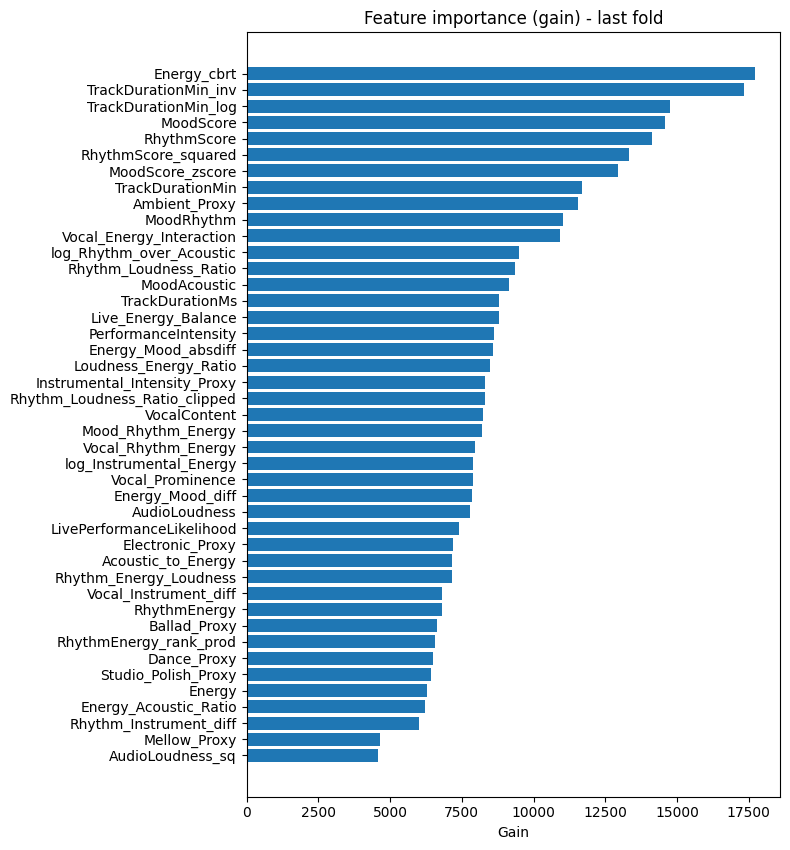

In [20]:
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_trainval, y_bins)):
    print(f"\n----- Fold {fold + 1}/{effective_folds} -----")
    X_tr, X_val_fold = X_trainval.iloc[tr_idx], X_trainval.iloc[val_idx]
    y_tr, y_val_fold = y_trainval.iloc[tr_idx], y_trainval.iloc[val_idx]

    # Create model (use final n_estimators determined earlier)
    model = XGBRegressor(
        n_estimators=n_estimators_final,
        random_state=RANDOM_SEED + fold,
        n_jobs=1,
        **best_params,
    )
    print(X_tr.shape)
    print(X_test.shape)
    # Fit model: because n_estimators is small (best_iteration), we skip early stopping here.
    # If you'd rather keep early stopping, set n_estimators to a large number and pass eval_set & early_stopping_rounds.
    model.fit(X_tr, y_tr, verbose=False)
# Predict val and test
    preds_val_fold = model.predict(X_val_fold)
    oof_preds[val_idx] = preds_val_fold
    rmse_fold = mean_squared_error(y_val_fold, preds_val_fold)
    fold_rmse_list.append(rmse_fold)
    print(f"Fold {fold+1} RMSE: {rmse_fold:.6f}")

    preds_test_fold = model.predict(X_test)
    test_preds_folds.append(preds_test_fold)

    # Save per-fold model
    model_path = os.path.join(OUTPUT_DIR, f"xgb_fold{fold+1}.joblib")
    joblib.dump(model, model_path)
    print(f"Saved model to {model_path}")
    models.append(model)

# ---------------- Aggregate CV results ----------------
cv_rmse = mean_squared_error(y_trainval, oof_preds)
print("\n=== CV results ===")
for i, r in enumerate(fold_rmse_list, 1):
    print(f" Fold {i} RMSE: {r:.6f}")
print(f"OOF (train+val) RMSE: {cv_rmse:.6f}")
print(f"Mean fold RMSE: {np.mean(fold_rmse_list):.6f} (std {np.std(fold_rmse_list):.6f})")

# Average test predictions across folds
test_preds_avg = np.mean(np.column_stack(test_preds_folds), axis=1)
test_rmse_avg = mean_squared_error(y_test, test_preds_avg)
print(f"Test RMSE (averaged over {len(test_preds_folds)} folds): {test_rmse_avg:.6f}")

# Save averaged test predictions and OOF predictions
pd.DataFrame({"prediction": test_preds_avg}).to_csv(os.path.join(OUTPUT_DIR, "test_predictions_avg.csv"), index=False)
pd.DataFrame({"oof_prediction": oof_preds, "target": y_trainval}).to_csv(os.path.join(OUTPUT_DIR, "oof_preds.csv"), index=False)
print(f"Saved averaged test predictions and OOF predictions to {OUTPUT_DIR}")

# ---------------- Optional: feature importance from last fold (or average later) ----------------
booster = models[-1].get_booster()
importance = booster.get_score(importance_type="gain")
if len(importance) == 0:
    print("No feature importance found.")
else:
    fi = pd.DataFrame(importance.items(), columns=["feature", "gain"]).sort_values("gain", ascending=True)
    plt.figure(figsize=(8, max(4, 0.2 * len(fi))))
    plt.barh(fi["feature"], fi["gain"])
    plt.xlabel("Gain")
    plt.title("Feature importance (gain) - last fold")
    plt.tight_layout()
    fig_path = os.path.join(OUTPUT_DIR, "feature_importance_gain_last_fold.png")
    plt.savefig(fig_path)
    print(f"Saved feature importance plot to {fig_path}")
    plt.show()


In [21]:
import sklearn, inspect
from sklearn import metrics
print("sklearn:", sklearn.__version__)
print("mean_squared_error signature:", inspect.signature(metrics.mean_squared_error))

sklearn: 1.7.2
mean_squared_error signature: (y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')


In [22]:
print(X_test.shape)
print(X.shape)


(104833, 69)
(524164, 69)


In [23]:
# ---------------- Train final model on full training data ----------------
X_full = X  # all training features
y_full = y  # all targets

final_model = XGBRegressor(
    n_estimators=n_estimators_final,
    random_state=RANDOM_SEED,
    n_jobs=1,
    **best_params,
)

print("Training final model on FULL data...")
final_model.fit(X_full, y_full, verbose=False)

# Predict on the FULL Kaggle test set (not split test)
X_test_full = test.drop(columns=["id"])
print(test.shape)
test_preds_final = final_model.predict(X_test_full)

# ---------------- Create submission file ----------------
submission = pd.DataFrame({
    "id": test["id"],
    "BeatsPerMinute": test_preds_final
})

sub_path = os.path.join(OUTPUT_DIR, "submission.csv")
submission.to_csv(sub_path, index=False)
print(f"✅ Submission file saved to: {sub_path}")

Training final model on FULL data...
(174722, 70)
✅ Submission file saved to: final_model_cv_output\submission.csv
